In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from tqdm import tqdm

In [2]:
def get_data(symbol):
   """
   Get stock data from yahoo finance.
   """
   stock_prices = yf.download(
                tickers=symbol,
                period="5y",
                interval="1d",
                auto_adjust=False,
                progress=False)
   stock_prices = stock_prices.reset_index()
   data_length = stock_prices.shape[0]
   stock_prices = stock_prices.iloc[1:]
   future_prices = stock_prices.iloc[-15:]
   historical_prices = stock_prices.iloc[:-15] 
   return historical_prices, future_prices.values.tolist()

In [3]:
def calculate_percentage_change(old, new):
    return ((new - old) * 100) / old

In [4]:
def create_returns(historical_price_info):
        """
        Create log return matrix, percentage return matrix, and mean return 
        vector
        """

        returns_matrix = []
        returns_matrix_percentages = []
        predicted_return_vectors = []
        for i in range(0, len(historical_price_info)):
            close_prices = list(historical_price_info[i]["Close"]) 
            log_returns = [math.log(close_prices[i] / close_prices[i - 1])
                           for i in range(1, len(close_prices))]
            percentage_returns = [((close_prices[i]-close_prices[i-1])/close_prices[i-1]*100) for i in range(1, len(close_prices))]

            total_data = len(close_prices)

            # Expected returns in future. We can either use historical returns as future returns on try to simulate future returns and take the mean. For simulation, you can modify the functions in simulator to use here.
            future_expected_returns = np.mean([(calculate_percentage_change(close_prices[i - 1], close_prices[i])) / (
                total_data - i) for i in range(1, len(close_prices))])  # More focus on recent returns

            # Add to matrices
            returns_matrix.append(log_returns)
            returns_matrix_percentages.append(percentage_returns)

            # Add returns to vector
            # Assuming that future returns are similar to past returns
            predicted_return_vectors.append(future_expected_returns)

        # Convert to numpy arrays for one liner calculations
        predicted_return_vectors = np.array(predicted_return_vectors)
        returns_matrix = np.array(returns_matrix)
        returns_matrix_percentages = np.array(returns_matrix_percentages)

        return predicted_return_vectors, returns_matrix, returns_matrix_percentages


In [6]:
stocks_list=['GOOG','MSFT','TSLA','AAPL','ABM','FBMS']
symbol_names = []
historical_price = []
future_price = []
data_dictionary={}

# Gather data for all stocks in a dictionary format
# Dictionary keys will be -> historical_prices, future_prices
for i in tqdm(range(len(stocks_list))):
    symbol = stocks_list[i]
    stock_price_data, future_prices= get_data(symbol)
    symbol_names.append(symbol)
    historical_price.append(stock_price_data)
    future_price.append(future_prices)
for i in range(0, len(symbol_names)):
    data_dictionary[symbol_names[i]] = {
            "historical_prices": historical_price[i],
            "future_prices": future_price[i]}

100%|██████████| 6/6 [00:14<00:00,  2.39s/it]


In [7]:
historical_price_info, future_prices = [], []
# Add data to lists
for symbol in symbol_names:
    historical_price_info.append(data_dictionary[symbol]["historical_prices"])
    future_prices.append(data_dictionary[symbol]["future_prices"])
# Get return matrices and vectors
predicted_return_vectors, returns_matrix, returns_matrix_percentages = create_returns(
            historical_price_info)

In [8]:
# Gets market index price
historical_price_market, future_prices_market=get_data("^GSPC")
# Calculate covariance matrix
covariance_matrix = np.cov(returns_matrix) 

In [9]:
def calculate_maximum_sharpe_portfolio(symbols, covariance_matrix, returns_vector):
		"""
		Inspired by: Eigen Portfolio Selection: A Robust Approach to Sharpe Ratio Maximization, https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3070416
		"""
		inverse_cov_matrix = np.linalg.pinv(covariance_matrix)
		ones = np.ones(len(inverse_cov_matrix))

		numerator = np.dot(inverse_cov_matrix, returns_vector)
		denominator = np.dot(np.dot(ones.transpose(), inverse_cov_matrix), returns_vector)
		msr_portfolio_weights = numerator / denominator
		
		portfolio_weights_dictionary = dict([(symbols[x], msr_portfolio_weights[x]) for x in range(0, len(msr_portfolio_weights))])
		return portfolio_weights_dictionary

In [10]:
def calculate_minimum_variance_portfolio(symbols, covariance_matrix):
		"""
		Inspired by: https://srome.github.io/Eigenvesting-II-Optimize-Your-Portfolio-With-Optimization/
		"""
		inverse_cov_matrix = np.linalg.pinv(covariance_matrix)
		ones = np.ones(len(inverse_cov_matrix)) 
		inverse_dot_ones = np.dot(inverse_cov_matrix,ones) 
		min_var_weights = inverse_dot_ones / np.dot(ones, inverse_dot_ones)
		portfolio_weights_dictionary = dict([(symbols[x], min_var_weights[x]) for x in range(0, len(min_var_weights))])
		return portfolio_weights_dictionary

In [18]:
msr_portfolio_weights_dictionary=calculate_maximum_sharpe_portfolio(
            symbol_names, covariance_matrix, predicted_return_vectors)
mvp_portfolio_weights_dictionary =calculate_minimum_variance_portfolio(
            symbol_names, covariance_matrix)

In [19]:
 def print_and_plot_portfolio_weights(weights_dictionary: dict, strategy, plot_num: int) -> None:
        print("\n-------- Weights for %s --------" % strategy)
        symbols = list(sorted(weights_dictionary.keys()))
        symbol_weights = []
        for symbol in symbols:
            print("Symbol: %s, Weight: %.4f" %
                  (symbol, weights_dictionary[symbol]))
            symbol_weights.append(weights_dictionary[symbol])

        # Plot
        width = 0.1
        x = np.arange(len(symbol_weights))
        plt.bar(x + (width * (plot_num - 1)) + 0.05,
                symbol_weights, label=strategy, width=width)
        plt.xticks(x, symbols, fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel("Symbols", fontsize=14)
        plt.ylabel("Weight in Portfolio", fontsize=14)
        plt.title("Portfolio Weights for Different Strategies", fontsize=14)


-------- Weights for Maximum Sharpe Portfolio (MSR) --------
Symbol: AAPL, Weight: -0.7173
Symbol: ABM, Weight: 0.5220
Symbol: FBMS, Weight: 0.4335
Symbol: GOOG, Weight: 1.5032
Symbol: MSFT, Weight: -0.2597
Symbol: TSLA, Weight: -0.4817

-------- Weights for Minimum Variance Portfolio (MVP) --------
Symbol: AAPL, Weight: 0.1307
Symbol: ABM, Weight: 0.0953
Symbol: FBMS, Weight: 0.2604
Symbol: GOOG, Weight: 0.3397
Symbol: MSFT, Weight: 0.1859
Symbol: TSLA, Weight: -0.0120


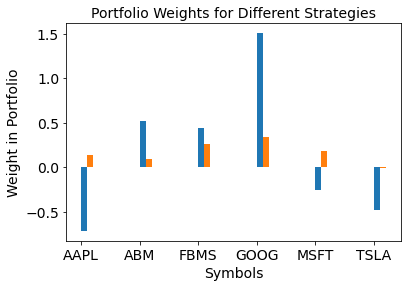

In [20]:
print_and_plot_portfolio_weights(
            msr_portfolio_weights_dictionary, 'Maximum Sharpe Portfolio (MSR)', plot_num=1)
print_and_plot_portfolio_weights(
            mvp_portfolio_weights_dictionary, 'Minimum Variance Portfolio (MVP)', plot_num=2)

In [21]:
def back_test(symbol_names, portfolio_weights_dictionary, portfolio_data_dictionary, historical_price_market,  market_chart, strategy_name):
        """
        Main backtest function. Takes in the portfolio weights and compares the portfolio returns with a market index of your choice.
        """

        # Get market returns during the backtesting time
        historical_price_market = list(historical_price_market["Close"])
        market_returns = [calculate_percentage_change(historical_price_market[i - 1], historical_price_market[i]) for i in range(1, len(historical_price_market))]
        market_returns_cumulative = np.cumsum(market_returns)

        # Get invidiual returns for each stock in our portfolio
        normal_returns_matrix = []
        for symbol in symbol_names:
            symbol_historical_prices = list(portfolio_data_dictionary[symbol]["historical_prices"]["Close"])
            symbol_historical_returns = [calculate_percentage_change(symbol_historical_prices[i - 1], symbol_historical_prices[i]) for i in range(1, len(symbol_historical_prices))]
            normal_returns_matrix.append(symbol_historical_returns)

        # Get portfolio returns
        normal_returns_matrix = np.array(normal_returns_matrix).transpose()
        portfolio_weights_vector = np.array([portfolio_weights_dictionary[symbol] for symbol in portfolio_weights_dictionary]).transpose()
        portfolio_returns = np.dot(normal_returns_matrix, portfolio_weights_vector)
        portfolio_returns_cumulative = np.cumsum(portfolio_returns)

        # Plot returns
        x = np.arange(len(portfolio_returns_cumulative))
        plt.plot(x, portfolio_returns_cumulative, linewidth = 2.0, label = strategy_name)
        plt.axhline(y = 0, linestyle = 'dotted', alpha = 0.3, color = 'black')
            
        if market_chart:
            x = np.arange(len(market_returns_cumulative))
            plt.plot(x, market_returns_cumulative, linewidth = 2.0, color = '#282828', label = 'Market Index', linestyle = '--')


        # Plotting styles
        plt.title("Backtest Results", fontsize = 14)
        plt.xlabel("Bars (Time Sorted)", fontsize = 14)
        plt.ylabel("Cumulative Percentage Return", fontsize = 14)
        plt.xticks(fontsize = 14)
        plt.yticks(fontsize = 14)

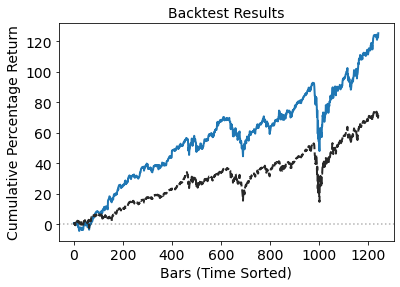

In [22]:
back_test(symbol_names,
          mvp_portfolio_weights_dictionary,
          data_dictionary, historical_price_market,
          market_chart=True,
          strategy_name='Minimum Variance Portfolio (MVP)')

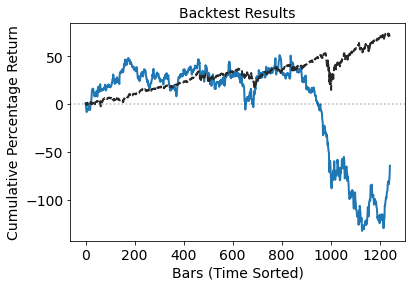

In [23]:
back_test(symbol_names, 
         msr_portfolio_weights_dictionary,
         data_dictionary,
         historical_price_market,
         market_chart=True,
         strategy_name='Maximum Sharpe Portfolio (MSR)')